# Global Power Rankings Hackathon


## Intro 
Hi my name is Giuseppe Frigeni and my nickname on discord is Camp. I started playing league in season 2 and i have been a fan of the pro scene since (i still remember watching season 2 Worlds and how hype it felt) even after I stopped playing the game some years ago. To this day i still watch the pro scene when i can and im watching daily this Worlds.

I recently started studying Data science and Machine Learning and I already had in mind a project for LoL when i stumbled on this hackaton. The project I had in mind is to create something similar to what they have in chess that in real time tells you who is winning using computer vision but i think is a bit too big and computing needy for a solo project.

After looking at this hackaton my thinking is to create an ELO system for the players. The ELO of a team is the average of the players and players gain or loose ELO on wins or losses.

I am not gonna use the stats of individual performance for two reasons: make the code faster without having to pull up the data for every single game (in tournament.json i can get everything i need) and because you cant say who performed better or worse just by looking at a scoreline or for an epic kill. Examples could be the Dyrus treatment where he would get camped during the game and have negative scorelines and then the team would win, should he get less ELO because his scoreline is bad? I think is very hard getting a factual insight in someone performance without looking at the game unfolding.

## ELO_players

In [137]:
import requests
import json
import gzip
import shutil
import time
import os
from io import BytesIO
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

To download the files i just used the code provided by you

In [2]:
S3_BUCKET_URL = "https://power-rankings-dataset-gprhack.s3.us-west-2.amazonaws.com"


def download_gzip_and_write_to_json(file_name):
   # If file already exists locally do not re-download game
   if os.path.isfile(f"{file_name}.json"):
       return

   response = requests.get(f"{S3_BUCKET_URL}/{file_name}.json.gz")
   if response.status_code == 200:
       try:
           gzip_bytes = BytesIO(response.content)
           with gzip.GzipFile(fileobj=gzip_bytes, mode="rb") as gzipped_file:
               with open(f"{file_name}.json", 'wb') as output_file:
                   shutil.copyfileobj(gzipped_file, output_file)
               print(f"{file_name}.json written")
       except Exception as e:
           print("Error:", e)
   else:
       print(f"Failed to download {file_name}")


def download_esports_files():
   directory = "esports-data"
   if not os.path.exists(directory):
       os.makedirs(directory)

   esports_data_files = ["leagues", "tournaments", "players", "teams", "mapping_data","tournaments_without_game_data","unfiltered_players","unfiltered_teams"]
   for file_name in esports_data_files:
       download_gzip_and_write_to_json(f"{directory}/{file_name}")


if __name__ == "__main__":
    download_esports_files()

esports-data/leagues.json written
esports-data/tournaments.json written
esports-data/players.json written
esports-data/teams.json written
esports-data/mapping_data.json written
esports-data/tournaments_without_game_data.json written
esports-data/unfiltered_players.json written
esports-data/unfiltered_teams.json written


First problem using pandas read_json the ids are too long and become wrong probably because of some approximation done by the command on large numbers so i used this workaround:

In [3]:
def json_to_df(path):
    with open(path, 'r') as j:
        contents = json.loads(j.read())

    df = pd.json_normalize(contents)
    return df

In [88]:
tournaments = json_to_df('esports-data/tournaments.json')
tournaments2 = json_to_df('esports-data/tournaments_without_game_data.json')
players = json_to_df('esports-data/unfiltered_players.json')
#unfiltered_players = json_to_df('esports-data/unfiltered_players.json')
leagues = json_to_df('esports-data/leagues.json')
teams = json_to_df('esports-data/unfiltered_teams.json')
mapping_data = json_to_df('esports-data/mapping_data.json')
new_leagues = pd.read_csv('new_leagues.csv')
new_leagues = new_leagues.drop('Unnamed: 0', axis = 1)
tournaments = pd.concat([tournaments, tournaments2], ignore_index=True)
tournaments.sort_values(by =['startDate'], inplace =True)
players = players.drop_duplicates(subset=['player_id'])
new_leagues.sort_values(by =['ELO'], ascending = False, inplace =True)

new_leagues is a the leagues dataframe modified by hand by me where i added a starting ELO for specific league.

In [9]:
new_leagues

,id,slug,ELO
16,98767975604431411,world,1600
15,98767991325878492,msi,1600
11,98767991314006698,lpl,1500
5,98767991310872058,lck,1500
36,123,eu,1400
8,98767991302996019,lec,1400
0,98767991299243165,lcs,1300
32,98767991335774713,lck_challengers_league,1200
12,104366947889790212,pcs,1200
7,105709090213554609,lco,1100


This is gonna be my main dataframe where i store the ELO of every player

In [20]:
ELO_players = pd.DataFrame(columns = ['id', 'handle', 'ELO'])
ELO_players

,id,handle,ELO


This is the main function to which i give a date and is gonna process all the tournaments starting with that date:

In [15]:
def advance_elo(date, ELO_players, new_leagues):
    for index, tournament in tournaments.iterrows():
        start_date = tournament.get("startDate", "")
        if start_date.startswith(date):
            if int(tournament['leagueId']) not in new_leagues.values:
                print(tournament['slug'] ,' not in leagues')
                continue
            print(f"Processing {tournament['slug']}")
            for stage in tournament["stages"]:
                for section in stage["sections"]:
                    for match in section["matches"]:
                        for game in match["games"]:
                            if game['id'] not in mapping_data.values:
                                    continue
                            if game["state"] == "completed":
                                elo_blue_side, elo_red_side, players_blue, players_red ,ELO_players = get_elo(game['id'], tournament['leagueId'], ELO_players,new_leagues)
                                # function to get the elo of both sides and the players playing in this game
                                k = 30 + 20 * (match['strategy']['count'] > 4) 
                                # coefficient for the game that is normally 30 but 50 for BO5 that normally imply more important games
                                result_blue_side = game['teams'][0]['result']['outcome'] # result of blue side
                                elo_change_blue, elo_change_red = elo_calc(elo_blue_side, elo_red_side, k, result_blue_side, stage['name']) 
                                #function to calculate the change in elo for both sides
                                ELO_players = elo_change(elo_change_blue, elo_change_red, ELO_players, players_blue, players_red, elo_blue_side, elo_red_side)
                                #function to change the elo of every single player
    
    return ELO_players

This is the function to calculate the ELO of the two teams

In [14]:
def get_elo(game_id,league_id, ELO_players,new_leagues):
    elo_blue_side = 0
    elo_red_side = 0
    players_blue = []
    players_red = []
    for i in range(1, 6, 1):
        participant_mapping = 'participantMapping.{}'.format(i)
        player_id = mapping_data.loc[mapping_data['esportsGameId'] == game_id][participant_mapping].item()
        if player_id not in players.values:
            continue
        players_blue.append(player_id)
        if player_id not in ELO_players.values :
            ELO_players = start_elo(player_id, league_id, ELO_players, new_leagues)
        elo_blue_side += ELO_players.loc[ELO_players['id'] == player_id]['ELO'].item()
    for i in range(6, 11, 1):
        participant_mapping = 'participantMapping.{}'.format(i)
        player_id = mapping_data.loc[mapping_data['esportsGameId'] == game_id][participant_mapping].item()
        if player_id not in players.values:
            continue
        players_red.append(player_id)
        if player_id not in ELO_players.values :
            ELO_players =start_elo(player_id, league_id, ELO_players, new_leagues)
        elo_red_side += ELO_players.loc[ELO_players['id'] == player_id]['ELO'].item()
    if len(players_blue) == 0:
        len_players_blue = 1
    else: 
        len_players_blue = len(players_blue)
    if len(players_red) == 0:
        len_players_red = 1
    else: 
        len_players_red = len(players_red)
    
    return elo_blue_side/len_players_blue, elo_red_side/len_players_red, players_blue, players_red, ELO_players

This is the function to insert a new player into the main dataframe

In [16]:
def start_elo(player_id, league_id, ELO_players, new_leagues):
    handle = players.loc[players['player_id'] == player_id]['handle'].item()
    ELO = new_leagues.loc[new_leagues['id'] == int(league_id)]['ELO'].item()
    elop = pd.DataFrame([{'id': player_id, 'handle' : handle, 'ELO': ELO}])
    ELO_players = pd.concat([ELO_players, elop], ignore_index = True)
    return ELO_players

This is the function to calculate the changes in ELO for the two teams based on the result of the game. I used the formula used in chess: $$E_{A}=\frac{1}{1+10^{\frac{R_{B}-R_{A}}{400}}}$$ to calculate the expected strenght of the A team wich then helps us calculate their change in ELO

In [17]:
def elo_calc(r_a, r_b, k, result, name):
    e_a = 1 / (1 + pow(10, ((r_b - r_a)/400)))
    e_b = 1 / (1 + pow(10, ((r_a - r_b)/400)))
    if result == 'win':
        r = 1
    else:
        r = 0
    change_a = int(k * (r - e_a)) + 10 * (name == 'knockouts') #this knockout check is to give a boost to players at Worlds
    change_b = int(k * (1 - r - e_b)) + 10 * (name == 'knockouts')
    return change_a, change_b

Function to change every players in the game ELO. Commented there is a try I did to reduce the elo of players that are playing in much worse teams than their ELO.

In [18]:
def elo_change(elo_change_blue, elo_change_red, ELO_players, players_blue, players_red, elo_blue, elo_red):
    for player in players_blue:
        elo = ELO_players.loc[ELO_players['id'] == player]['ELO'].item()
        #diff = elo - elo_blue
        #if (diff / elo) > (0.2 * elo):
        #    elo *= 0.9
        new_elo = elo + elo_change_blue
        ELO_players.loc[ELO_players['id'] == player, 'ELO'] = new_elo
    for player in players_red:
        elo = ELO_players.loc[ELO_players['id'] == player]['ELO'].item()
        #diff = elo - elo_red
        #if (diff / elo) > (0.2 * elo):
        #    elo *= 0.9
        new_elo = elo + elo_change_red
        ELO_players.loc[ELO_players['id'] == player, 'ELO'] = new_elo
    return ELO_players

Let's see the results of 2023 and how much time it takes

In [21]:
%%time
ELO_players = advance_elo('2023', ELO_players, new_leagues)

tft_events_2023  not in leagues
season_2023_kickoff  not in leagues
ddh_opening_2023  not in leagues
golden_league_opening_2023  not in leagues
Processing lpl_spring_2023
el_opening_2023  not in leagues
Processing ultraliga_spring_2023
Processing lck_challengers_spring_2023
Processing nlc_spring_2023
Processing superliga_spring_2023
stars_league_opening_2023  not in leagues
liga_master_opening_2023  not in leagues
Processing lck_spring_2023
Processing tcl_spring_2023
vdl_opening_2023  not in leagues
Processing prime_league_spring_2023
Processing lfl_spring_2023
Processing lec_winter_2023
Processing nacl_spring_2023
Processing nacl_qualifiers_1_spring_2023
Processing lco_split_1_2023
honor_league_opening_2023  not in leagues
Processing cblol_2023_split_1
Processing lla_opening_2023
Processing elite_series_spring_2023
Processing gll_spring_2023
Processing ebl_spring_2023
Processing cblol_academy_2023_split_1
Processing hitpoint_masters_spring_2023
Processing liga_portuguesa_spring_2023
P

Let's see the results:

In [24]:
ELO_players.sort_values(by =['ELO'], ascending = False, inplace =True)

In [30]:
ELO_players.head(30)

,id,handle,ELO
237,102186485482484390,Doran,1797
240,107492068702410338,Peyz,1797
241,105501709748188393,Delight,1797
238,98767975916458257,Peanut,1797
239,99871276342168416,Chovy,1797
269,98767991747728851,Faker,1736
1410,101388912796120370,369,1725
1414,100205573984889078,MISSING,1725
1411,101671284628761661,Kanavi,1725
1413,98767975906852059,Ruler,1725


And just from this snippet we can see the problems of this method: <br>
How is the jdg players under in elo in respect to the geng players even tho jdg dominated also summer? <br>
Why are the weibo players so high up on the ladder?<br>
Where are lng and blg players not present?<br>
ON is present but just him?<br>
And if we go look more deep gets worse.
My conclusions from this is that there are problems in the database of games for the players (I manually checked in the database and ON changes name and ID in summer) and so I'll try and do directly with the teams. 

## ELO_teams

These are the functions for the teams:

In [89]:
def advance_elo_teams(year_month, ELO_teams, new_leagues):
    for index, tournament in tournaments.iterrows():
        start_date = tournament.get("startDate", "")
        if start_date.startswith(year_month):
            if int(tournament['leagueId']) not in new_leagues.values:
                print(tournament['slug'] ,' not in leagues')
                continue
            print(f"Processing {tournament['slug']}")
            for stage in tournament["stages"]:
                for section in stage["sections"]:
                    for match in section["matches"]:
                        if match['teams'][0]['id'] not in teams.values or match['teams'][1]['id'] not in teams.values:
                            continue
                        elo_blue_side, elo_red_side, ELO_teams = get_elo_teams(match['teams'], tournament['leagueId'], ELO_teams,new_leagues)
                        n_games = match['strategy']['count']
                        result_blue_side = match['teams'][0]['result']['gameWins']
                        blue_wins = result_blue_side / n_games
                        k = 30 + 70 * (n_games > 4)
                        elo_change_blue, elo_change_red = elo_calc_teams(elo_blue_side, elo_red_side, k, blue_wins)
                        ELO_teams = elo_change_teams(elo_change_blue, elo_change_red, ELO_teams, match['teams'])
    return ELO_teams

In [90]:
def get_elo_teams(teams, league_id, ELO_teams, new_leagues):
    teams_elo = []
    for team in teams:
        team_id = team['id']
        if team_id not in ELO_teams.values:
            ELO_teams = start_elo_teams(team_id, league_id, ELO_teams, new_leagues)
        teams_elo.append(ELO_teams.loc[ELO_teams['id'] == team_id]['ELO'].item())
    return teams_elo[0], teams_elo[1], ELO_teams

In [82]:
def start_elo_teams(team_id, league_id, ELO_teams, new_leagues):
    elo = new_leagues.loc[new_leagues['id'] == int(league_id)]['ELO'].item()
    slug = teams.loc[teams['team_id'] == team_id]['slug'].item()
    elot = pd.DataFrame({'id': [team_id], 'name': [slug], 'ELO':[elo]})
    ELO_teams = pd.concat([ELO_teams, elot], ignore_index=True)
    return ELO_teams

In [34]:
def elo_calc_teams(r_a, r_b, k, r):
    e_a = 1 / (1 + pow(10, ((r_b - r_a)/400)))
    e_b = 1 / (1 + pow(10, ((r_a - r_b)/400)))
    change_a = int(k * (r - e_a))
    change_b = int(k * (1 - r - e_b))
    return change_a, change_b

In [35]:
def elo_change_teams(elo_change_blue, elo_change_red, ELO_teams, teams):
    team_blue_side = teams[0]['id']
    elo = ELO_teams.loc[ELO_teams['id'] == team_blue_side]['ELO'].item()
    new_elo = elo + elo_change_blue
    ELO_teams.loc[ELO_teams['id'] == team_blue_side, 'ELO'] = new_elo
    
    team_red_side = teams[1]['id']
    elo = ELO_teams.loc[ELO_teams['id'] == team_red_side]['ELO'].item()
    new_elo = elo + elo_change_red
    ELO_teams.loc[ELO_teams['id'] == team_red_side, 'ELO'] = new_elo
    return ELO_teams

In [62]:
ELO_teams = pd.DataFrame(columns = ['id', 'name', 'ELO'])
ELO_teams

,id,name,ELO


In [37]:
%%time
ELO_teams = advance_elo_teams('2023',ELO_teams, new_leagues)

tft_events_2023  not in leagues
season_2023_kickoff  not in leagues
ddh_opening_2023  not in leagues
golden_league_opening_2023  not in leagues
Processing lpl_spring_2023
el_opening_2023  not in leagues
Processing ultraliga_spring_2023
Processing lck_challengers_spring_2023
Processing nlc_spring_2023
Processing superliga_spring_2023
stars_league_opening_2023  not in leagues
liga_master_opening_2023  not in leagues
Processing lck_spring_2023
Processing tcl_spring_2023
vdl_opening_2023  not in leagues
Processing prime_league_spring_2023
Processing lfl_spring_2023
Processing lec_winter_2023
Processing nacl_spring_2023
Processing nacl_qualifiers_1_spring_2023
Processing lco_split_1_2023
honor_league_opening_2023  not in leagues
Processing cblol_2023_split_1
Processing lla_opening_2023
Processing elite_series_spring_2023
Processing gll_spring_2023
Processing ebl_spring_2023
Processing cblol_academy_2023_split_1
Processing hitpoint_masters_spring_2023
Processing liga_portuguesa_spring_2023
P

In [38]:
ELO_teams.sort_values(by =['ELO'], ascending = False, inplace =True)

In [54]:
ELO_teams.head(30)

,id,name,ELO
5,99566404852189289,jd-gaming,1679
1,99566404853854212,bilibili-gaming,1626
58,100205573495116443,geng,1625
7,99566404850008779,lng-esports,1623
60,99566404579461230,kt-rolster,1600
64,98767991853197861,t1,1587
16,99566404853058754,weibo-gaming,1559
94,98767991926151025,g2-esports,1547
55,100725845018863243,dwg-kia,1538
8,99566404845279652,oh-my-god,1537


As we can see it's much better when working directly on teams and also takes so little time! (60 times less than when working on players)

So now we have the global ranking:

To have the ranking of a specific list of teams using the IDs:

In [53]:
def ranking_teams(team_list, ELO_teams):
    teams = pd.DataFrame(columns = ['id', 'name', 'ELO'])
    for team_id in team_list:
        ELO_teams[ELO_teams['id'] == team_id]
        teams = pd.concat([teams, ELO_teams[ELO_teams['id'] == team_id]], ignore_index=True)
    return teams

This is an example with LPL teams:

In [56]:
lpl_list = ['99566404852189289','99566404853854212','99566404850008779','99566404853058754','99566404845279652','99566404854685458']
lpl = ranking_teams(lpl_list, ELO_teams)
lpl

,id,name,ELO
0,99566404852189289,jd-gaming,1679
1,99566404853854212,bilibili-gaming,1626
2,99566404850008779,lng-esports,1623
3,99566404853058754,weibo-gaming,1559
4,99566404845279652,oh-my-god,1537
5,99566404854685458,top-esports,1530


Now for the ranking coming into a tournament i made this function that takes the 8 month before and makes a ranking of the team participating in that tournament:

In [78]:
def get_tournament_rank(tournament_id):
    ELO_teams = pd.DataFrame(columns = ['id', 'name', 'ELO'])
    start_date = tournaments.loc[tournaments['id'] == tournament_id]['startDate'].item()
    start = datetime.strptime(start_date, '%Y-%m-%d')
    date = start - timedelta(days = 240)
    while date < start :
        ELO_teams = advance_elo_teams(date.strftime('%Y-%m-%d'), ELO_teams, new_leagues)
        date = date + timedelta(days=1)
    tournament_teams = get_tournament_teams(tournament_id)
    tournament_teams = pd.merge(tournament_teams, ELO_teams, on="id", how="left")
    tournament_teams.sort_values(by =['ELO'], ascending = False, inplace =True)
    return tournament_teams

In [76]:
def get_tournament_teams(tournament_id):
    tournament_teams = pd.DataFrame(columns = ['id'])
    stages = tournaments.loc[tournaments['id'] == tournament_id, 'stages'].item()
    
    for stage in stages:
        for section in stage["sections"]:
            for match in section["matches"]:
                for team in match["teams"]:
                    team_id = team['id']
                    if team_id not in tournament_teams.values:
                        df = pd.DataFrame({'id': [team_id]})
                        tournament_teams = pd.concat([tournament_teams, df], ignore_index=True)
    
    return tournament_teams

Let's try with MSI 2023 id 110198981276611770 

In [91]:
%%time
msi_rankings = get_tournament_rank('110198981276611770')
msi_rankings

Processing lla_promotion_2022
Processing worlds_2022
tft_events_2023  not in leagues
season_2023_kickoff  not in leagues
ddh_opening_2023  not in leagues
golden_league_opening_2023  not in leagues
Processing lpl_spring_2023
el_opening_2023  not in leagues
Processing ultraliga_spring_2023
Processing lck_challengers_spring_2023
Processing nlc_spring_2023
Processing superliga_spring_2023
stars_league_opening_2023  not in leagues
liga_master_opening_2023  not in leagues
Processing lck_spring_2023
Processing tcl_spring_2023
vdl_opening_2023  not in leagues
Processing prime_league_spring_2023
Processing lfl_spring_2023
Processing lec_winter_2023
Processing nacl_spring_2023
Processing nacl_qualifiers_1_spring_2023
Processing lco_split_1_2023
honor_league_opening_2023  not in leagues
Processing cblol_2023_split_1
Processing lla_opening_2023
Processing elite_series_spring_2023
Processing gll_spring_2023
Processing ebl_spring_2023
Processing cblol_academy_2023_split_1
Processing hitpoint_masters

,id,name,ELO
12,99566404852189289,jd-gaming,1742
8,100205573495116443,geng,1693
10,98767991853197861,t1,1663
0,99566404853854212,bilibili-gaming,1626
9,103461966965149786,mad-lions,1584
4,98767991926151025,g2-esports,1571
11,98767991877340524,cloud9,1547
3,98767991954244555,gam-esports,1481
7,100285330168091787,detonation-focusme,1462
2,99294153824386385,golden-guardians,1455


And with this i finished the required outputs but I still would like to see if it's possible to do a player ranking and also get more old data so...

## ELO history and my data

So let's get my own data!

I never built a scraper before so this was a really good exercise for me. I scraped gol.gg all the available series on the site

I used Scrapy and this is the spider i programmed:

In [ ]:
import scrapy


class Spider(scrapy.Spider):
    name = "srs"
    start_urls = ['https://gol.gg/game/stats/{}/page-summary/'.format(i) for i in range(1, 53426)]
    
    def parse(self, response):
        blue_side = response.css('div.col-4.col-sm-5')
        blue_side_name = blue_side.css("a::text").get()
        red_side = response.css('div.col-4.col-sm-5')[1]
        red_side_name = red_side.css("a::text").get()
        rows = response.css('div.row.pb-1')
        n_games = len(rows.css('h1::text').getall()) // 3
        blue_side_wins = []
        for i in range(0, 3 * n_games, 3):
            if rows.css('h1::text')[i].get() == 'WIN':
                blue_side_wins.append(rows.css('h1::text')[i].get())
        wins = len(blue_side_wins)
        players_blue_place = response.css("div.col-12.col-sm-6.pb-4")[2]
        players_blue = players_blue_place.css("a::text").getall()
        players_red_place = response.css("div.col-12.col-sm-6.pb-4")[3]
        players_red = players_red_place.css("a::text").getall()
        date = response.css("div.col-12.col-sm-5::text").get()[:10]
        tournament = response.css("div.col-12.col-sm-7")
        tournament_name = tournament.css("a::text").get()
        yield {
            "date": date,
            "tournament_name": tournament_name,
            "blue_side_team": blue_side_name,
            "red_side_team": red_side_name,
            "blue_side_wins": wins,
            "n_games": n_games,
            "players_blue": players_blue,
            "players_red": players_red
        }

And this is the result: (after some cleaning on the dataframe)

In [119]:
series = json_to_df('gamesoflegends/series.json')
df = series.rename_axis('index').sort_values(by = ['date', 'index'], ascending = [True, True])
slug = df['tournament_name'].str.split(' ')
slug = slug.to_frame()
slug['slug'] = 'NaN'
for index, game in slug.iterrows():
    for word in game['tournament_name']:
        if word.lower() in new_leagues.values:
            slug.at[index,'slug'] = word.lower()
            break
df.insert(1, 'league', slug['slug'])
df = df.drop(df[df['league'] == 'NaN'].index)
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df = df.drop(df[df['n_games'] == 0].index)
llist = df[["blue_side_team","red_side_team"]].values.tolist()
df['teams'] = [sorted(l) for l in llist]
col = ['teams']
df = df.loc[((df[col].shift() != df[col])).any(axis=1)]
df = df.drop(['teams'], axis=1)

In [120]:
df.loc[df['red_side_team'] == 'DWG KIA' , 'red_side_team'] = 'Dplus KIA'
df.loc[df['blue_side_team'] == 'DWG KIA' , 'blue_side_team'] = 'Dplus KIA'
df.loc[df['red_side_team'] == 'DAMWON Gaming' , 'red_side_team'] = 'Dplus KIA'
df.loc[df['blue_side_team'] == 'DAMWON Gaming' , 'blue_side_team'] = 'Dplus KIA'
df.loc[df['red_side_team'] == 'SK Telecom T1' , 'red_side_team'] = 'T1'
df.loc[df['blue_side_team'] == 'SK Telecom T1' , 'blue_side_team'] = 'T1'
df.loc[df['red_side_team'] == 'SKTelecom T1' , 'red_side_team'] = 'T1'
df.loc[df['blue_side_team'] == 'SKTelecom T1' , 'blue_side_team'] = 'T1'

In [121]:
df

,date,league,tournament_name,blue_side_team,red_side_team,blue_side_wins,n_games,players_blue,players_red,year,month
index,,,,,,,,,,,
140,2013-09-16,world,Season 3 World Championship,GamingGear,Team SoloMid,0,1,"[Nbs, Alunir, Mazzerin, DeadlyBrother, Inspirro]","[Dyrus, TheOddOne, Reginald, WildTurtle, Xpecial]",2013,9
141,2013-09-16,world,Season 3 World Championship,T1,Lemondogs,1,1,"[Impact, bengi, Faker, Piglet, PoohManDu]","[Zorozero, dexter, Nukeduck, Tabzz, Mithy]",2013,9
142,2013-09-16,world,Season 3 World Championship,Team SoloMid,OMG,0,1,"[Dyrus, TheOddOne, Reginald, WildTurtle, Xpecial]","[Gogoing, LoveLing, Cool, San, bigpomelo]",2013,9
143,2013-09-16,world,Season 3 World Championship,Lemondogs,GamingGear,1,1,"[Zorozero, dexter, Nukeduck, Tabzz, Mithy]","[Nbs, Alunir, Mazzerin, DeadlyBrother, Inspirro]",2013,9
144,2013-09-16,world,Season 3 World Championship,OMG,T1,1,1,"[Gogoing, LoveLing, Cool, San, bigpomelo]","[Impact, bengi, Faker, Piglet, PoohManDu]",2013,9
...,...,...,...,...,...,...,...,...,...,...,...
46434,2023-09-09,pcs,PCS Summer Playoffs 2023,PSG Talon,CTBC Flying Oyster,3,5,"[Azhi, JunJia, Maple, Wako, Woody]","[Rest, Gemini, JimieN, Shunn, ShiauC]",2023,9
46453,2023-09-09,cblol,CBLOL Split 2 Playoffs 2023,paiN Gaming,LOUD,1,4,"[Wizer, Cariok, dyNquedo, Bvoy, ProDelta]","[Robo, Croc, Tinowns, Route, Ceos]",2023,9
46483,2023-09-09,vcs,VCS Summer Playoffs 2023,Team Whales,GAM Esports,1,4,"[Sparda, BeanJ, Gloryy, Artemis, CBL]","[Kiaya, Levi, Kati, Slayder, Palette]",2023,9


This is a dataframe contaning the last 10 years of league of legends series. And now i want to get the ELO histories:

In [154]:
%%time

ELO_players = pd.DataFrame(columns = ['handle', 'ELO'])
ELO_teams = pd.DataFrame(columns = ['name', 'ELO'])

for index, game in df.iterrows():
    
    elo_blue_side, elo_red_side, ELO_players= get_elo_series(game['league'], game['players_blue'], game['players_red'], ELO_players, new_leagues)
    
    n_games = game['n_games']
    result_blue_side = game['blue_side_wins']
    blue_wins = result_blue_side / n_games
    k = 30 + 70 * (n_games > 4)
    elo_change_blue, elo_change_red = elo_calc_series(elo_blue_side, elo_red_side, k, blue_wins)

    ELO_teams = change_ELO_teams(elo_blue_side + elo_change_blue, game['blue_side_team'], ELO_teams)
    ELO_teams = change_ELO_teams(elo_red_side + elo_change_red, game['red_side_team'], ELO_teams)
    ELO_players = elo_change_series(elo_change_blue, elo_change_red, ELO_players, game['players_blue'], game['players_red'])
    
    if (game['month'] == 1 or game['month'] == 6) and  f"{game['year']}-{game['month']}" not in ELO_players.columns:
        ELO_players[f"{game['year']}-{game['month']}"] = ELO_players['ELO']
        ELO_teams[f"{game['year']}-{game['month']}"] = ELO_teams['ELO']
        print(f"Reached {game['year']}-{game['month']}")

Reached 2014-1
Reached 2014-6
Reached 2015-1
Reached 2015-6
Reached 2016-1
Reached 2016-6
Reached 2017-1
Reached 2017-6
Reached 2018-1
Reached 2018-6
Reached 2019-1
Reached 2019-6
Reached 2020-1
Reached 2020-6
Reached 2021-1
Reached 2021-6
Reached 2022-1
Reached 2022-6
Reached 2023-1
Reached 2023-6
CPU times: user 15min 2s, sys: 242 ms, total: 15min 2s
Wall time: 17min 30s


In [107]:
def get_elo_series(league_slug, players_blue, players_red, ELO_players, new_leagues):
    elo_blue_side = 0
    elo_red_side = 0
    
    for player in players_blue :
        if player not in ELO_players.values :
            ELO_players = start_elo_series(player, league_slug, ELO_players, new_leagues)
        elo_blue_side += ELO_players.loc[ELO_players['handle'] == player]['ELO'].item()
    
    for player in players_red :
        if player not in ELO_players.values :
            ELO_players = start_elo_series(player, league_slug, ELO_players, new_leagues)
        elo_red_side += ELO_players.loc[ELO_players['handle'] == player]['ELO'].item()
        
    return elo_blue_side // len(players_blue), elo_red_side // len(players_red), ELO_players

In [108]:
def start_elo_series(player, league_slug, ELO_players, new_leagues):
    ELO = new_leagues.loc[new_leagues['slug'] == league_slug]['ELO'].item()
    elop = pd.DataFrame({'handle' : [player], 'ELO': [ELO]})
    ELO_players = pd.concat([ELO_players, elop], ignore_index = True)
    return ELO_players

In [109]:
def elo_calc_series(r_a, r_b, k, r):
    e_a = 1 / (1 + pow(10, ((r_b - r_a)/400)))
    e_b = 1 / (1 + pow(10, ((r_a - r_b)/400)))
    change_a = int(k * (r - e_a))
    change_b = int(k * (1 - r - e_b))
    return change_a, change_b

In [110]:
def elo_change_series(elo_change_blue, elo_change_red, ELO_players, players_blue, players_red):
    for player in players_blue:
        elo = ELO_players.loc[ELO_players['handle'] == player]['ELO'].item()
        new_elo = elo + elo_change_blue
        ELO_players.loc[ELO_players['handle'] == player, 'ELO'] = new_elo
    for player in players_red:
        elo = ELO_players.loc[ELO_players['handle'] == player]['ELO'].item()
        new_elo = elo + elo_change_red
        ELO_players.loc[ELO_players['handle'] == player, 'ELO'] = new_elo
    return ELO_players

In [111]:
def change_ELO_teams(elo, team, ELO_teams):
    
    if team not in ELO_teams.values:
        elot = pd.DataFrame({'name': [team], 'ELO':[elo]})
        ELO_teams = pd.concat([ELO_teams, elot], ignore_index=True)
        return ELO_teams
    
    ELO_teams.loc[ELO_teams['name'] == team, 'ELO'] = elo
    return ELO_teams

Let's see the dataframes:

In [155]:
ELO_players.sort_values(by =['ELO'], ascending = False, inplace =True)
ELO_players.head(25)

,handle,ELO,2014-1,2014-6,2015-1,2015-6,2016-1,2016-6,2017-1,2017-6,...,2019-1,2019-6,2020-1,2020-6,2021-1,2021-6,2022-1,2022-6,2023-1,2023-6
12,Faker,2139,1699,1699,1699,1738,1860,1847,1875,1898,...,1813,1873,1910,1962,1930,1944,2002,2099,2092,2125
1182,Chovy,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1619,1670,1714,1765,1789,1805,1770,1788,1891,1945
559,Ruler,1983,NaN,NaN,NaN,NaN,NaN,1533,1669,1780,...,1716,1642,1667,1755,1836,1841,1806,1839,1956,1981
936,Yagao,1971,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1591,1609,1586,1686,1709,1738,1648,1721,1824,1941
299,xiaohu,1963,NaN,NaN,NaN,1484,1474,1574,1532,1591,...,1718,1690,1720,1693,1723,1880,1867,1928,1914,1923
1406,369,1955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1579,1650,1679,1741,1760,1752,1825,1928,1953
427,Peanut,1950,NaN,NaN,NaN,NaN,1492,1553,1603,1626,...,1620,1546,1571,1563,1592,1618,1685,1721,1824,1878
207,Deft,1911,NaN,NaN,1619,1749,1741,1741,1796,1743,...,1798,1831,1823,1879,1900,1935,1883,1867,1981,1931
607,Lehends,1908,NaN,NaN,NaN,NaN,NaN,NaN,1487,1487,...,1603,1654,1698,1637,1510,1505,1566,1602,1719,1815
54,Sneaky,1902,1599,1560,1471,1396,1368,1410,1528,1605,...,1923,1918,1902,1902,1902,1902,1902,1902,1902,1902


In [145]:
ELO_teams.sort_values(by =['ELO'], ascending = False, inplace =True)
ELO_teams.head(25)

,name,ELO,2014-1,2014-6,2015-1,2015-6,2016-1,2016-6,2017-1,2017-6,...,2019-1,2019-6,2020-1,2020-6,2021-1,2021-6,2022-1,2022-6,2023-1,2023-6
165,JD Gaming,1855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1571,1574,1542,1666,1689,1705,1568,1666,1769,1853
234,Gen.G eSports,1818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1577,1490,1535,1621,1702,1703,1668,1708,1817,1746
65,KT Rolster,1777,NaN,NaN,NaN,1544,1613,1613,1753,1700,...,1701,1506,1504,1601,1535,1515,1494,1564,1593,1684
178,Bilibili Gaming,1759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1490,1562,1610,1547,1536,1521,1587,1594,1569,1729
2,T1,1758,1699,1699,1699,1625,1739,1649,1704,1743,...,1581,1721,1715,1698,1622,1702,1689,1768,1767,1800
276,LNG Esports,1749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1466,1528,1459,1457,1468,1606,1651,1648,1698
63,Samsung Galaxy,1736,NaN,NaN,NaN,1497,1462,1545,1603,1707,...,1736,1736,1736,1736,1736,1736,1736,1736,1736,1736
275,Victory Five,1721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1470,1439,1350,1532,1502,1379,1683,1721,1721
253,Dplus KIA,1712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1495,1542,1664,1626,1799,1748,1781,1636,1743,1744
83,Longzhu Gaming,1702,NaN,NaN,NaN,NaN,NaN,1448,1497,1581,...,1702,1702,1702,1702,1702,1702,1702,1702,1702,1702


In [146]:
ELO_players = ELO_players.set_index('handle')
ELO_teams = ELO_teams.set_index('name')

In [147]:
column = ELO_players.pop("ELO")
ELO_players.insert(20, "2023-9", column)
ELO_players = ELO_players.transpose()

In [148]:
column = ELO_teams.pop("ELO")
ELO_teams.insert(20, "2023-9", column)
ELO_teams = ELO_teams.transpose()

In [149]:
def plot(df, names):
    plt.figure(figsize=(10, 6))
    for name in names:
        df[name].plot()
    plt.xlabel('', fontsize=20)
    plt.ylabel('ELO', fontsize=12)
    plt.legend()
    plt.show()

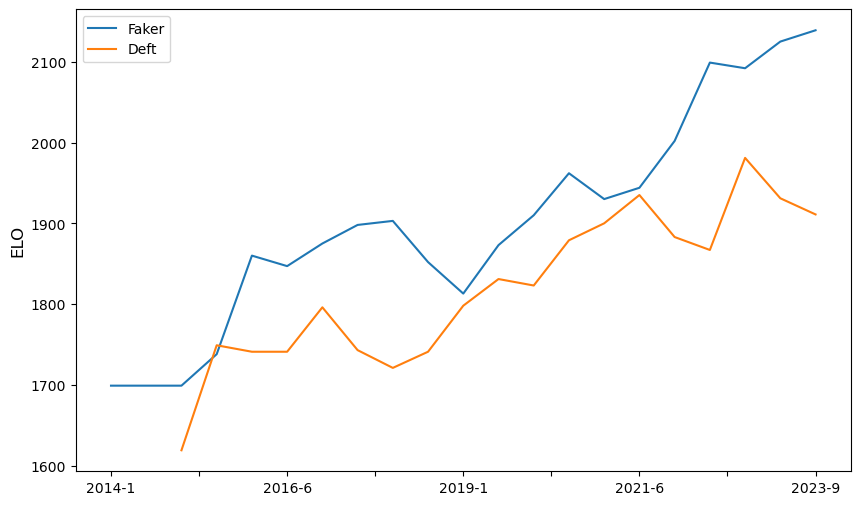

In [150]:
plot(ELO_players, ['Faker','Deft'])

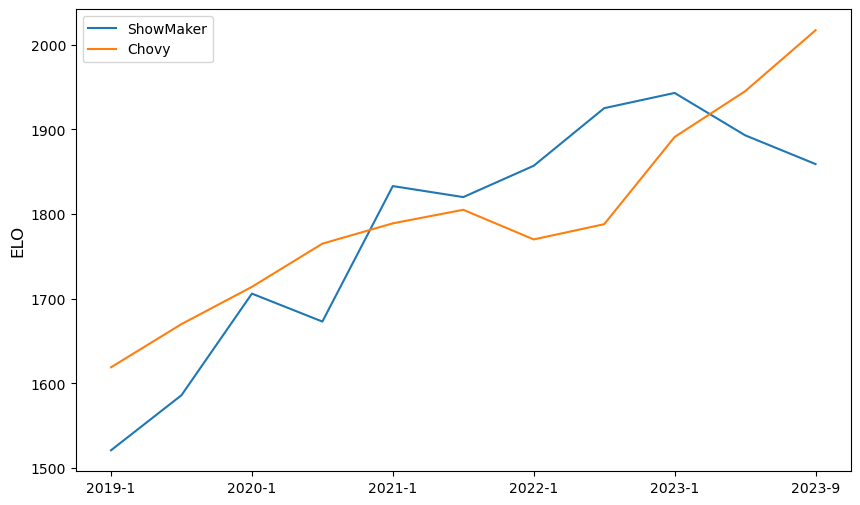

In [151]:
plot(ELO_players, ['ShowMaker','Chovy'])

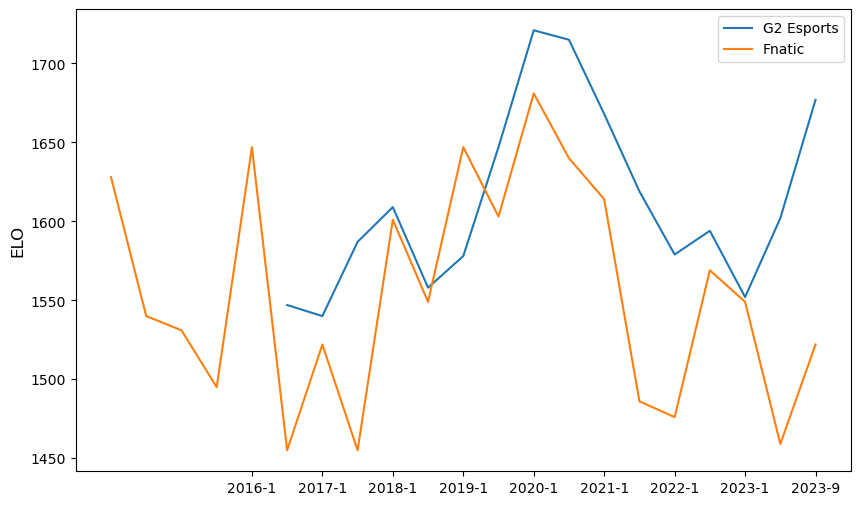

In [152]:
plot(ELO_teams, ['G2 Esports','Fnatic'])

These are some of the graphs we can get from this history of ELO

## Conclusions

I was able to get the three request outputs from the original data and at really fast speed (I think it takes a minute to run the entirety of the ELO_teams part) As we can see from my data as well as the original is that working on players seems less reliable and much more time consuming even if in theory should be a much more precise approach.

I feel lucky to have stumbled on this hackaton that made me actually try my data science skills and i learned even a lot of new things!(scraping it's pretty fun) I want to thank Riot for the data and the game that I still watch (I still have hopes for the west at this worlds) and AWS for letting me use their platform (I only used their notebooks linking them to my github).